# 0. Import Libraries

In [97]:
import sys
PARENT_PATH = '../..'
sys.path.append(PARENT_PATH)

import lasio
import permeability_predictor as pp
import classifier

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime

from facies_prediction import FaciesPredictor
from facies_prediction.model import CustomResNet

# 1. Lithofacies Prediction

## 1.1 Load Model pre-trained model


In [98]:
facies_model = CustomResNet() # Create an instance of the model

# Load the state dictionary
facies_model.load_state_dict(torch.load(f'{PARENT_PATH}/extras/saved_models/facies_model.pth'))

# Don't forget to set the model to evaluation mode if you're doing inference
facies_model.eval()

/home/gems-wse23/miniconda3/envs/ads-geopredictor/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/gems-wse23/miniconda3/envs/ads-geopredictor/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## 1.2 Load Facies Result

In [99]:
facies_csv = pd.read_csv(f'{PARENT_PATH}/extras/saved_facies_result/facies.csv')
facies_df = facies_csv
facies_df

,Start Depth,End Depth,Predicted Class
0,1812.05,1812.35,is
1,1812.35,1812.50,is
2,1812.50,1812.72,is
3,1812.72,1813.05,is
4,1813.05,1813.30,nc
...,...,...,...
101,1837.25,1837.50,sh
102,1837.50,1837.75,sh
103,1837.75,1838.00,sh
104,1838.00,1838.20,sh


# 2. Permeability Prediction

## 2.1 Preprocess Data

In [100]:
# Get las data
well = lasio.read(f'{PARENT_PATH}/Sources/blinded_well/205-21b-3_logs.las') # Dont forget to change the path. The las file is too big and cannot be uploaded to github.
well_df_las = well.df()
well_df_las.index.name = 'Depth'
well_df_las

,AT10,AT20,AT30,AT60,AT90,CALI,DENC,DENS,DTC,DTS_1,DTS_2,GR,NEUT,PEF,SP,RDEP
Depth,,,,,,,,,,,,,,,,
300.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8125,0.9029
300.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2500,0.9748
300.3048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2500,1.0102
300.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.3750,1.0369
300.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8125,1.0558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299.3356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.1875,2.7990
2299.4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.3750,2.9237
2299.6404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0000,2.9004


In [101]:
well_poro_csv = pd.read_csv(f'{PARENT_PATH}/Sources/blinded_well/porosity.csv')
well_poro_csv.columns = ['Depth', 'Porosity']

well_poro_csv['Depth'] = well_poro_csv['Depth'].astype(float)   # Change the data type of the depth column to float
well_poro_csv.set_index('Depth', inplace=True)
well_poro_csv

,Porosity
Depth,
1812.05,23.1
1812.35,24.4
1812.50,21.9
1812.72,21.3
1813.05,21.8
...,...
1837.25,31.6
1837.50,NaN
1837.75,NaN


In [102]:
# Ensure DataFrames are sorted by the key
df1 = well_df_las.sort_values(by='Depth')
df2 = well_poro_csv.sort_values(by='Depth')

# Merge using merge_asof
merged_df = pd.merge_asof(df1, df2, on='Depth', direction='nearest', tolerance=0.2)
merged_df.set_index('Depth', inplace=True)
df_interest = merged_df
df_interest.reset_index(inplace=True)
df_interest

,Depth,AT10,AT20,AT30,AT60,AT90,CALI,DENC,DENS,DTC,DTS_1,DTS_2,GR,NEUT,PEF,SP,RDEP,Porosity
0,300.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8125,0.9029,NaN
1,300.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2500,0.9748,NaN
2,300.3048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2500,1.0102,NaN
3,300.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.3750,1.0369,NaN
4,300.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8125,1.0558,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13119,2299.3356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.1875,2.7990,NaN
13120,2299.4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.3750,2.9237,NaN
13121,2299.6404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.0000,2.9004,NaN
13122,2299.7928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.4375,2.7593,NaN


In [103]:
# Select the features columns. It has to be the following: ['true depth', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RSHAL', 'POROSITY\n(HELIUM)']
df_interest_features = df_interest[['Depth','DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'AT20', 'Porosity']]
df_interest_features.columns = ['true depth', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RSHAL', 'POROSITY\n(HELIUM)']
# df_interest_features[(df_interest_features['true depth'] >= 1812) & (df_interest_features['true depth'] <= 1838.3)]
df_interest_features

,true depth,DENS,DTC,GR,NEUT,PEF,RSHAL,POROSITY\n(HELIUM)
0,300.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,300.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300.3048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,300.4572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13119,2299.3356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13120,2299.4880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13121,2299.6404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13122,2299.7928,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.2 Predict Permeability

In [104]:
# Instantiate the predictor
pp_model            = pp.permeability_predict(folder_path=f'{PARENT_PATH}/Sources/data/labels/permeability/preprocessed_data')
perm_predict_series = pp_model.predict(features_df=df_interest_features)  # Get Prediction
perm_predict_df     = pd.DataFrame(perm_predict_series, columns=['Permeability'])
perm_predict_df

,Permeability
0,252.346542
1,252.346542
2,252.346542
3,252.346542
4,252.346542
...,...
13119,259.355865
13120,259.355865
13121,259.355865
13122,259.355865


# 3. Visualize Data

In [105]:
# Merge all of the dataframes
visual_df = df_interest_features
visual_df['Permeability']   = perm_predict_df['Permeability'].to_list()
visual_df['Facies']         = [np.nan for i in range(len(visual_df['Permeability']))]   # The values in the list are non-relevant to the plotting.

/home/gems-wse23/miniconda3/envs/ads-geopredictor/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gems-wse23/miniconda3/envs/ads-geopredictor/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


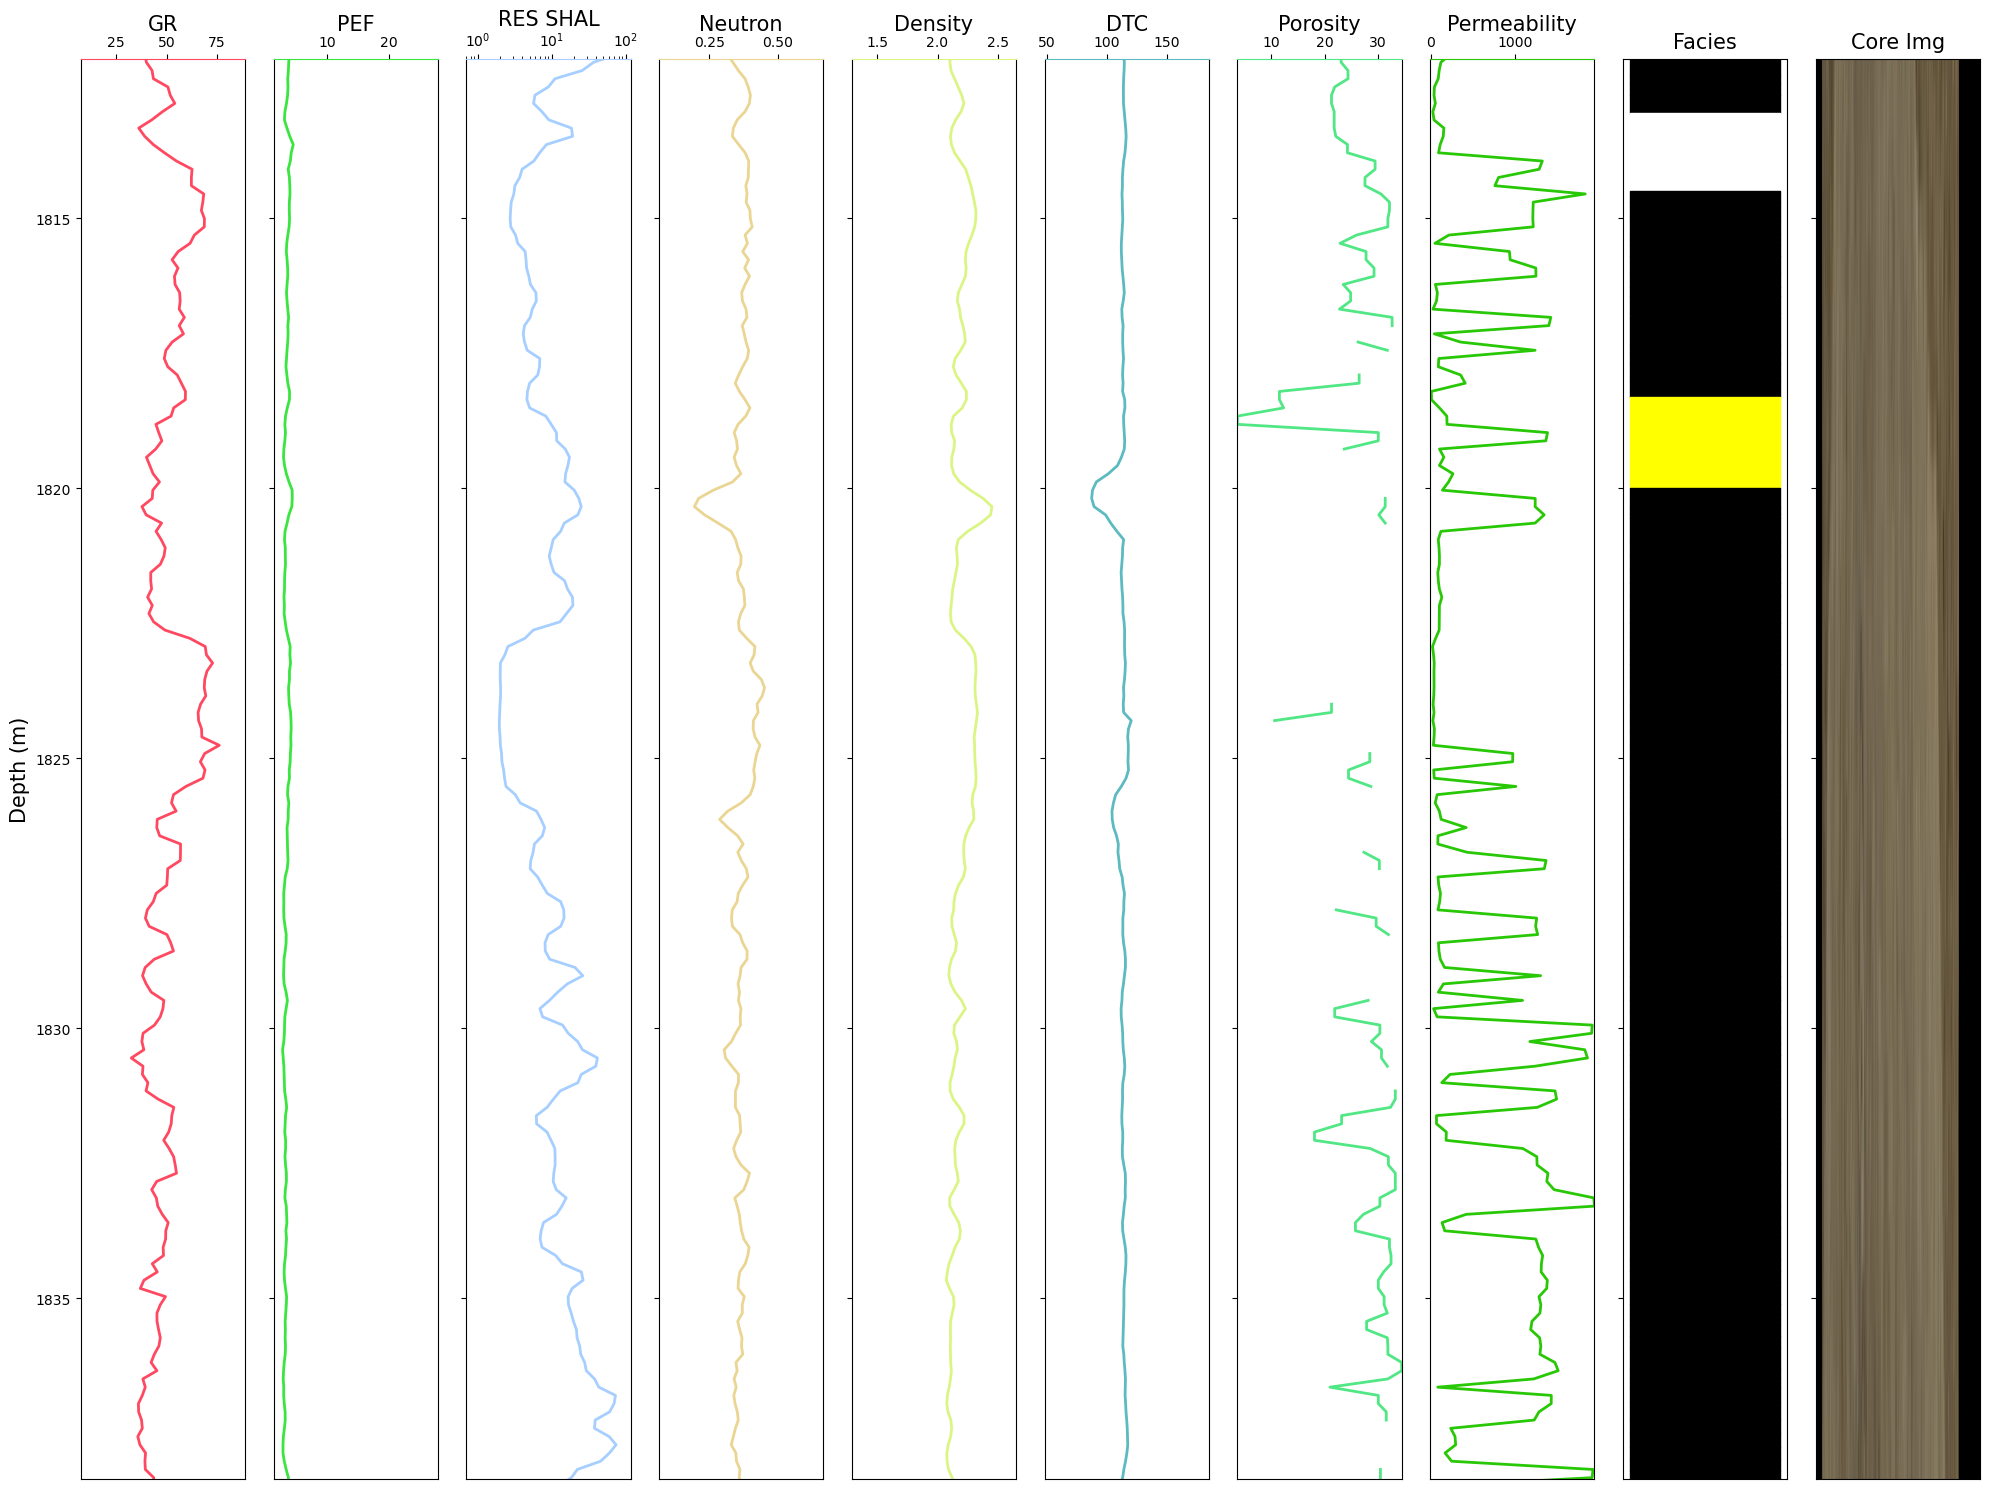

In [111]:
import random
import matplotlib.image as mpimg

# file_path = f'{PARENT_PATH}/Sources/blinded_well/preprocessed/205-21b-3_image.npy'
core_np_data = np.load(f'{PARENT_PATH}/Sources/blinded_well/preprocessed/205-21b-3_image.npy')

facies_colors = {
    'nc'    : '#ffffff',    # white
    's'     : '#ffff00',    # yellow
    'os'    : '#00ff00',    # green
    'bs'    : '#ffffff',    # white
    # 'is'    : '#310A0B',    # shades of brown
    # 'ih'    : '#743A36',    # shades of brown
    # 'sh'    : '#785C33',    # shades of brown
    'is'    : '#000000',    # black
    'ih'    : '#000000',    # black
    'sh'    : '#000000',    # black
    }

# It has to be the following: ['true depth', 'DENS', 'DTC', 'GR', 'NEUT', 'PEF', 'RSHAL', 'POROSITY\n(HELIUM)']
show_titles = {
    'true depth'        : 'Depth',
    'DENS'              : 'Density',
    'DTC'               : 'DTC',
    'GR'                : 'GR',
    'NEUT'              : 'Neutron',
    'PEF'               : 'PEF',
    'RSHAL'             : 'RES SHAL',
    'POROSITY\n(HELIUM)': 'Porosity',
    'Permeability'      : 'Permeability',
    # 'Facies'            : 'Facies',
    # 'Core Img'          : 'Core Img',
    }

show_df = visual_df[['true depth', 'GR', 'PEF', 'RSHAL', 'NEUT', 'DENS', 'DTC', 'POROSITY\n(HELIUM)', 'Permeability', 'Facies']]

def GetRandomColor():
    '''
    Get a random color.
    '''
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def Plot_Data(log_df: pd.DataFrame, ylim:[None,list]=None):
    '''
    Plot simple well log data.
    '''
    depth_list = log_df['true depth']

    # Initiate the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=len(log_df.columns), figsize=(20, 15), sharey=True)

    # Plot the well logs
    for i in range(len(log_df.columns)):

        # Set y axis title
        if i == 0: 
            ax[i].set_ylabel('Depth (m)',fontsize=15)
        
        # Plot Core in the last track
        if i+1 == len(log_df.columns):
            ax[i].imshow(core_np_data, aspect='auto')
            
            ax[i].set_xlabel('Core Img',fontsize=15)
            ax[i].xaxis.set_ticks_position("top")
            ax[i].xaxis.set_label_position("top")
            ax[i].set_xticks([])
            ax[i].spines['top'].set_edgecolor('#000000')
            continue
        
        # Get Parameters
        column_name = log_df.columns[i+1]

        if column_name == 'Facies':

            # Plot the facies
            for d in range(len(facies_df['Start Depth'])):
                start_depth = facies_df['Start Depth'][d]
                end_depth   = facies_df['End Depth'][d]
                facies_class= facies_df['Predicted Class'][d]
                color       = facies_colors[facies_class]
                ax[i].fill_betweenx([start_depth, end_depth], 0, 1, color=color)

            # X Axis
            ax[i].set_xlabel('Facies',fontsize=15)
            ax[i].xaxis.set_ticks_position("top")
            ax[i].xaxis.set_label_position("top")
            ax[i].set_xticks([])
            ax[i].spines['top'].set_edgecolor('#000000')

            continue
        
        else:
            # Get random color
            random_color = GetRandomColor()

            # Plot the log
            ax[i].plot(log_df[column_name], depth_list, '-', color=random_color,linewidth=2)

            # X Axis
            ax[i].set_xlabel(show_titles[column_name],fontsize=15)
            ax[i].set_xlim(log_df[column_name].min(),log_df[column_name].max())
            ax[i].xaxis.set_ticks_position("top")
            ax[i].xaxis.set_label_position("top")
            ax[i].spines['top'].set_edgecolor(random_color)

            # Custom Setting
            if column_name == 'RSHAL': ax[i].set_xscale('log')
    
    # Y Axis
    if ylim != None:    
        ax[i].set_ylim(ylim[0],ylim[1])
        # ax[i].set_yticks([ylim[0],ylim[1]])
    else:               
        ax[i].set_ylim(depth_list.min(),depth_list.max())
        ax[i].set_yticks([depth_list.min(),depth_list.max()])
    
    ax[i].invert_yaxis()
    fig.tight_layout()
    now = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    fig.savefig(f'{PARENT_PATH}/extras/saved_images/img_{now}.jpg', dpi=300)
    
    return 

# Plot Data
ylim_start = facies_df['Start Depth'].min()
ylim_end   = facies_df['End Depth'].max()
Plot_Data(show_df, ylim=[ylim_start,ylim_end])